In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import string
%matplotlib notebook
from PIL import Image

#pre-processing
import re
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
english_stemmer=nltk.stem.SnowballStemmer('english')



#modeling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from sklearn.naive_bayes import GaussianNB,BernoulliNB,MultinomialNB

#CV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

In [2]:
df = pd.read_csv('791531.csv', encoding='latin-1')
df.columns

Index(['_unit_id', '_golden', '_unit_state', '_trusted_judgments',
       '_last_judgment_at', 'gender', 'gender:confidence', 'profile_yn',
       'profile_yn:confidence', 'created', 'description', 'fav_number',
       'gender_gold', 'link_color', 'name', 'profile_yn_gold', 'profileimage',
       'retweet_count', 'sidebar_color', 'text', 'tweet_coord', 'tweet_count',
       'tweet_created', 'tweet_id', 'tweet_location', 'user_timezone'],
      dtype='object')

### Intro

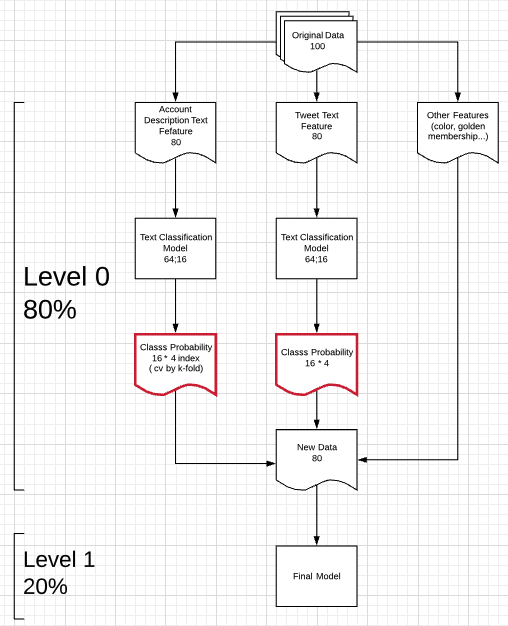

In [3]:
Image.open('screenshot3.png')

### A. Cleaning

#### Crop

In [4]:
df = df[['text', 'description', 'sidebar_color', 'gender:confidence', 'gender']]
df.dropna(inplace = True)
df.drop(df[(df['gender'] == 'unknown') | 
           (df['gender'] == 'brand')].index, inplace = True)
df.drop(df[df['gender:confidence'] != 1].index, inplace = True)


In [5]:
df.shape

(8766, 5)

In [6]:
df.head(1)

,text,description,sidebar_color,gender:confidence,gender
0,Robbie E Responds To Critics After Win Against...,i sing my own rhythm.,FFFFFF,1.0,male


In [7]:
#two funcitons for normalization
def doc_features(doc):
    #HTML
    pattern = r"http\S+"
    documents = re.sub(pattern, " ", doc)
    
    #'-' letters
    documents = re.sub("[^a-zA-Z]"," ", doc)
    
    #To lower case
    words = documents.lower().split()
    
    #Stop words (nltk)
    stop = set(stopwords.words("english"))
    words = [w for w in words if not w in stop]
    
    #Stemmer & Return
    features = []
    stemmer = english_stemmer
    for word in words:
        features.append(stemmer.stem(word))
        
    return(features)
    
def text_cleaner(text):
    clean_text = []
    for i in text:
        clean_text.append(' '.join(doc_features(i)))
    
    return clean_text

In [8]:
df['text'] = text_cleaner(df['text']);
df['description'] = text_cleaner(df['description']);

In [9]:
del df['gender:confidence']

In [10]:
df

,text,description,sidebar_color,gender
0,robbi e respond critic win eddi edward worldti...,sing rhythm,FFFFFF,male
1,felt like friend live stori https co arng yhno...,author novel fill famili drama romanc,C0DEED,male
3,hi jordanspieth look url use ifttt typic see a...,mobil guy er shazam googl kleiner perkin yahoo...,C0DEED,male
4,watch neighbour sky catch neighb xxx xxx,ricki wilson best frontman kaiser chief best b...,0,female
5,ive seen peopl train lamp chair tvs etc https ...,know,0,female
...,...,...,...,...
20044,need ride home practic rain hard asf,love,C0DEED,female
20045,lookupondeath fine drink tea love,rp,C0DEED,female
20046,greg hardi good player get face dez bryant lea...,whatev like problem chargern foreverroy edm mu...,0,male
20047,miss peopl still never want see,teambarcelona look lost follow follow heart br...,C0DEED,male


#### Map

In [11]:
df['gender'] = df['gender'].map({ 'male':1, 'female':0})

In [12]:
df.groupby('gender').count()[['sidebar_color']]

,sidebar_color
gender,
0,4616
1,4150


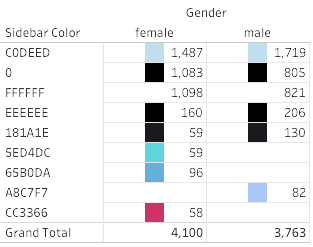

In [13]:
Image.open('screenshot1.png')
#This chart only display "sidebar_color" counts > 50;
#Except sidebar_color = 0, all the color display with real RGB

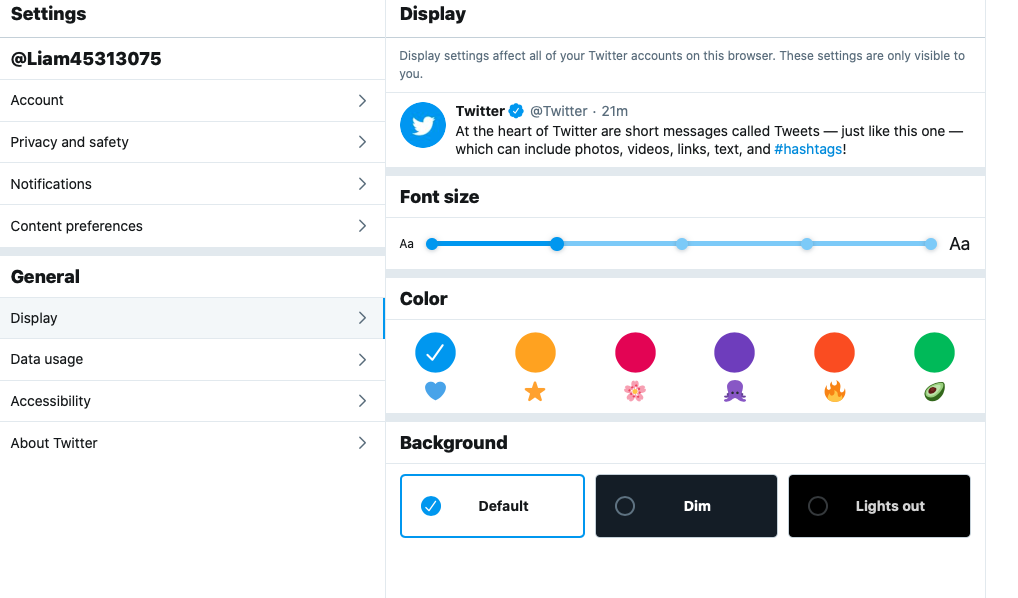

In [14]:
#By this chart, we hard to tell how sidebar color correlates to gender
#Moreover, current Twitter seems not allowing customized sidebar color 
#only 6 theme colors
Image.open('screenshot2.png')

### B. Preprocessing

In [52]:
def split(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=100)
    return X_train, X_test, y_train, y_test

def text_vec_convert(X_train, X_test):
    vectorizer = CountVectorizer(ngram_range = (1,1))
    X_train_dtm = vectorizer.fit_transform(X_train)
    X_test_dtm = vectorizer.transform(X_test)
    #print(vectorizer.vocabulary_)
    return X_train_dtm, X_test_dtm


def MNB_modeling(X_train_dtm, X_test_dtm, y_train, y_test):

    clf = MultinomialNB(alpha = 1)
    clf.fit(X_train_dtm, y_train)
    return clf.score(X_test_dtm, y_test)



In [53]:
def get_acc(X, y):
    X_train, X_test, y_train, y_test = split(X, y)
    X_train_dtm, X_test_dtm = text_vec_convert(X_train, X_test)
    return MNB_modeling(X_train_dtm, X_test_dtm, y_train, y_test)

In [54]:
df.head(5)

,text,description,sidebar_color,gender
0,robbi e respond critic win eddi edward worldti...,sing rhythm,FFFFFF,1
1,felt like friend live stori https co arng yhno...,author novel fill famili drama romanc,C0DEED,1
3,hi jordanspieth look url use ifttt typic see a...,mobil guy er shazam googl kleiner perkin yahoo...,C0DEED,1
4,watch neighbour sky catch neighb xxx xxx,ricki wilson best frontman kaiser chief best b...,0,0
5,ive seen peopl train lamp chair tvs etc https ...,know,0,0


In [55]:
8776*0.7

6143.2

In [56]:
#we will utilize df1 for level 0 model training and df2 for level 1 testing
df1 = df[['text','description','gender']].loc[6140:]
df2 = df[['text','description','gender']].loc[:6140]

In [57]:
df1.head(1)

,text,description,gender
6143,tbh hardest stress thing colleg still know want,effort waken watch live joy bay area boulder,0


In [58]:
df1.shape

(5997, 3)

### Level 0 Modeling

In [61]:
print (get_acc(df1['text'], df1['gender']))
print (get_acc(df1['description'], df1['gender']))

0.5883333333333334
0.655
